In [9]:
import numpy as np

import torch

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

import sys
sys.path.append("..")
sys.path.append("../scripts/")

from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('../report_plots/report.mplstyle')


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


# Figure 4

In [10]:
mouse_id = 'Mouse12'
session_id = '120806'
subset = 'hdc'
phase = 'wake'

bin_size = 160  # ms
delay = 0
single_spikes = False

checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

dataset_dict_hdc = dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

model_dict_hdc = {
                'seed': 123, 
                'll_mode': 'U-ec-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }

subset='nonhdc'
dataset_dict_nonhdc = dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

model_dict_nonhdc = {
                'seed': 123, 
                'll_mode': 'U-ec-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            } 

units:  85  hdc units:  22
units:  85  hdc units:  22


In [11]:
batch_size = 500  # size of time segments of each batch in dataset below

models_test_ll_hdc = np.zeros((4, 4))
models_train_ll_hdc = np.zeros((4, 4))
models_test_ll_nonhdc = np.zeros((3, 4))
models_train_ll_nonhdc = np.zeros((3, 4))

for i, mode in enumerate(['ew', 'ec', 'eq', 'qd']):
    for j, U in enumerate([1, 2, 3, 4]):
        ll_mode = 'U-' + mode + '-' + str(U)
        model_dict_hdc['ll_mode'] = ll_mode
        model_dict_nonhdc['ll_mode'] = ll_mode

        total_test_ll_hdc = 0
        total_train_ll_hdc = 0
        total_test_ll_nonhdc = 0
        total_train_ll_nonhdc = 0
        num_cvs_hdc = 0
        num_cvs_nonhdc = 0
        for cv_run in [0, 1, 2, 3, 4]:
            # model and train/test split based on which validation fold is given by cv_run
            try:
                modelfit, training_results, fit_set, validation_set = lib.models.load_model(
                    checkpoint_dir, model_dict_hdc, dataset_dict_hdc, HDC.enc_used, 
                    delay, cv_run, batch_size, gpu_dev
                )

                ll = lib.helper.RG_pred_ll(
                    modelfit, validation_set, neuron_group=None, ll_mode='MC', 
                    ll_samples=1, cov_samples=1, beta=0.0
                )
                total_test_ll_hdc += ll
                num_cvs_hdc += 1

                ll = lib.helper.RG_pred_ll(
                    modelfit, fit_set, neuron_group=None, ll_mode='MC', 
                    ll_samples=1, cov_samples=1, beta=0.0
                )
                total_train_ll_hdc += ll
            except FileNotFoundError:
                print(f'HD model {ll_mode} with cv_run={cv_run} not found.')

            if U < 4:
                try:
                    modelfit, training_results, fit_set, validation_set = lib.models.load_model(
                        checkpoint_dir, model_dict_nonhdc, dataset_dict_nonhdc, HDC.enc_used, 
                        delay, cv_run, batch_size, gpu_dev
                    )

                    ll = lib.helper.RG_pred_ll(
                        modelfit, validation_set, neuron_group=None, ll_mode='MC', 
                        ll_samples=1, cov_samples=1, beta=0.0
                    )
                    total_test_ll_nonhdc += ll
                    num_cvs_nonhdc += 1

                    ll = lib.helper.RG_pred_ll(
                        modelfit, fit_set, neuron_group=None, ll_mode='MC', 
                        ll_samples=1, cov_samples=1, beta=0.0
                    )
                    total_train_ll_nonhdc += ll
                except FileNotFoundError:
                    print(f'Non-HD model {ll_mode} with cv_run={cv_run} not found.')
    
    
        models_test_ll_hdc[j, i] = total_test_ll_hdc / num_cvs_hdc
        models_train_ll_hdc[j, i] = total_train_ll_hdc / num_cvs_hdc
        if U < 4:
            models_test_ll_nonhdc[j, i] = total_test_ll_nonhdc / num_cvs_nonhdc
            models_train_ll_nonhdc[j, i] = total_train_ll_nonhdc / num_cvs_nonhdc

Non-HD model U-ew-3 with cv_run=3 not found.
HD model U-ec-2 with cv_run=0 not found.
HD model U-eq-4 with cv_run=3 not found.
HD model U-qd-4 with cv_run=2 not found.


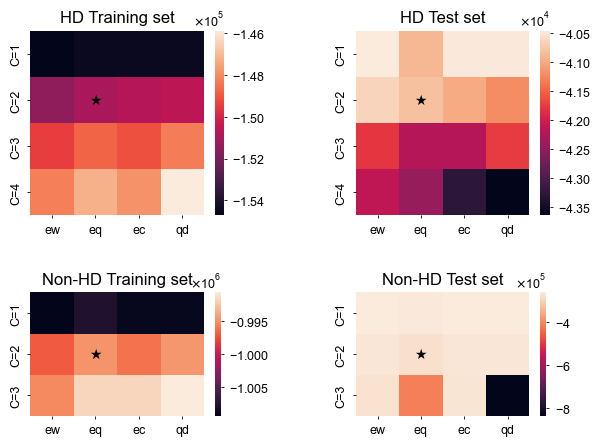

In [24]:
fig = plt.figure(figsize=(7, 5))

gs = gridspec.GridSpec(2, 2, fig, wspace=0.5, height_ratios=[3,2], hspace=0.5)


data_train = pd.DataFrame(models_train_ll_hdc, columns=['ew', 'eq', 'ec', 'qd'], index=['C=1','C=2','C=3','C=4'])
text = np.array([['', '', '', ''],
                 ['', '$\\bigstar$', '', ''],
                 ['', '', '', ''],
                 ['', '', '', '']])
ax = fig.add_subplot(gs[0,0])
sns.heatmap(data_train, ax=ax, annot=text, fmt="", annot_kws={'c':'black'})
ax.set_title('HD Training set')
cb = ax.collections[-1].colorbar
cb.formatter.set_scientific('%.2e')
cb.formatter.set_powerlimits((0,0))
cb.formatter.set_useMathText(True)

data_test = pd.DataFrame(models_test_ll_hdc, columns=['ew', 'eq', 'ec', 'qd'], index=['C=1','C=2','C=3','C=4'])
ax = fig.add_subplot(gs[0,1])
sns.heatmap(data_test, ax=ax, annot=text, fmt="", annot_kws={'c':'black'})
ax.set_title('HD Test set')
cb = ax.collections[-1].colorbar
cb.formatter.set_scientific('%.2e')
cb.formatter.set_powerlimits((0,0))
cb.formatter.set_useMathText(True)


data_train = pd.DataFrame(models_train_ll_nonhdc, columns=['ew', 'eq', 'ec', 'qd'], index=['C=1', 'C=2','C=3'])
ax = fig.add_subplot(gs[1,0])
text = text[:3, :]
sns.heatmap(data_train, ax=ax, annot=text, fmt="",annot_kws={'c':'black'})
ax.set_title('Non-HD Training set')
cb = ax.collections[-1].colorbar
cb.formatter.set_scientific('%.2e')
cb.formatter.set_powerlimits((0,0))
cb.formatter.set_useMathText(True)


data_test = pd.DataFrame(models_test_ll_nonhdc, columns=['ew', 'eq', 'ec', 'qd'], index=['C=1','C=2','C=3'])
ax = fig.add_subplot(gs[1,1])
sns.heatmap(data_test, ax=ax, annot=text, fmt="",annot_kws={'c':'black'})
ax.set_title('Non-HD Test set')
cb = ax.collections[-1].colorbar
cb.formatter.set_scientific('%.2e')
cb.formatter.set_powerlimits((0,0))
cb.formatter.set_useMathText(True)

plt.savefig("/homes/vn283/UCM-interpret/figures/model_selection.pdf", format="pdf", bbox_inches="tight")